In [124]:
import os
import time
import math
import copy
import json
import logging

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [125]:
from sklearn.metrics import accuracy_score

In [126]:
from sklearn.datasets import make_blobs, make_classification
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

%matplotlib inline

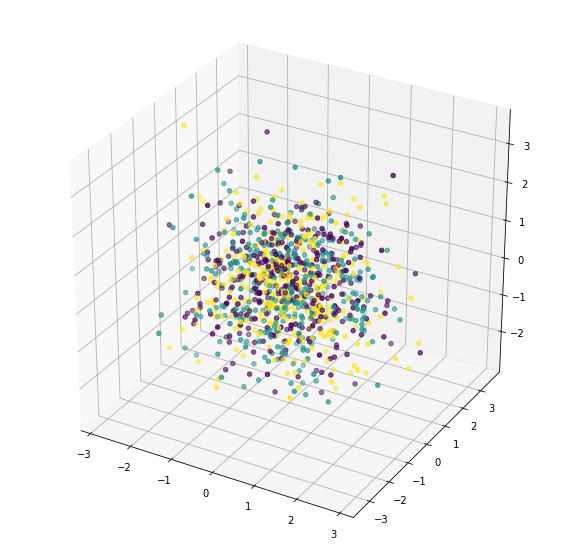

In [127]:
XX, yyy = make_blobs(2000, n_features=3, random_state=42)

X = XX[0:1000]
yy = yyy[0:1000]

X_test = XX[1000:]
yy_test = yyy[1000:]

X = torch.randn_like(torch.tensor(X)).numpy()
X_test = torch.randn_like(torch.tensor(X_test)).numpy()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=yy)


# convert to pytorch tensors
X = torch.FloatTensor(X)
y = torch.zeros(X.size(0), 3)
for idx, _ in enumerate(yy):
    y[idx, _] = 1.0

X_test = torch.FloatTensor(X_test)
   
y_test = torch.zeros(X_test.size(0), 3)
for idx, _ in enumerate(yy_test):
    y_test[idx, _] = 1.0

In [104]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 3),
            nn.ReLU(True),
            nn.Linear(3, 3)
        )
    
    def forward(self, x):
        return self.layers(x)

    def compute_loss(self, x, y):
        out = self(x)
        return F.binary_cross_entropy_with_logits(out, y)


### Train a network until it learns to predict all ones for the output

In [105]:
def sem_loss(probs):
    s = torch.zeros(1)
    
    for i, p_i in enumerate(probs):
        s_part = p_i
        for j, p_j in enumerate(probs):
            if i == j:
                continue
            s_part = torch.mul(s_part, (1 - p_j))
        s += s_part
    return -1 * torch.log(s)

In [107]:
np.random.seed(42)
torch.manual_seed(42)

net = Net()

opt = optim.Adam(net.parameters())
for i in range(3000):    
    opt.zero_grad()
    loss = net.compute_loss(X, torch.ones(X.size(0), 3))
    loss.backward()
    opt.step()
#     print(loss.item())
    
    with torch.no_grad():
        
        y_pred = torch.sigmoid(net(X))
        # accuracy_score(yy, y_pred.detach().numpy().argmax(1))
        y_pred[y_pred > 0.5] = 1
        all_ones = (y_pred == 1.0).view(-1).sum()
#         print(all_ones)
        if all_ones == np.prod(y_pred.shape):
            break

print("All ones: DONE!")            
### Now train only with the semantic loss and note the number of constraints it satisfies 
opt = optim.Adam(net.parameters(), lr=0.01)
loss_ot = []
sat_ot = []
for i in range(500):    
    opt.zero_grad()
    out = net(X)
    batch_loss = torch.zeros(X.size(0))
    for i, o in enumerate(out):
        batch_loss[i] = sem_loss(torch.sigmoid(o))
    loss = batch_loss.mean()
    loss.backward()
    opt.step()

    loss_ot.append(loss.item())
    
    
    with torch.no_grad():
        y_pred = torch.sigmoid(net(X))
        logits = copy.deepcopy(y_pred)
        logits[logits > 0.5] = 1
        logits[logits <= 0.5] = 0
        sat = logits.sum(dim=1)
        sat = (sat == 1).sum()
        sat_ot.append(sat)
        print(sat, loss.item())
#         if sat == X.size(0):
                    

All ones: DONE!
tensor(0) 1.9344931840896606
tensor(0) 1.8802818059921265
tensor(0) 1.8281011581420898
tensor(0) 1.7779501676559448
tensor(0) 1.729817509651184
tensor(0) 1.683689832687378
tensor(0) 1.6395573616027832
tensor(0) 1.597399115562439
tensor(0) 1.5571857690811157
tensor(0) 1.5188783407211304
tensor(0) 1.4824271202087402
tensor(0) 1.4477825164794922
tensor(0) 1.4148931503295898
tensor(0) 1.3837029933929443
tensor(0) 1.354162335395813
tensor(0) 1.3262078762054443
tensor(9) 1.2997751235961914
tensor(14) 1.274796962738037
tensor(20) 1.2512027025222778
tensor(24) 1.2289355993270874
tensor(34) 1.2079205513000488
tensor(51) 1.1880857944488525
tensor(69) 1.1693716049194336
tensor(84) 1.1517144441604614
tensor(100) 1.1350597143173218
tensor(120) 1.1193478107452393
tensor(156) 1.1045199632644653
tensor(194) 1.0905226469039917
tensor(226) 1.0773049592971802
tensor(267) 1.0648229122161865
tensor(319) 1.0530288219451904
tensor(361) 1.0418776273727417
tensor(400) 1.0313278436660767
tensor(

tensor(963) 0.22495028376579285
tensor(964) 0.22078432142734528
tensor(965) 0.2166496217250824
tensor(967) 0.21254274249076843
tensor(969) 0.2084495723247528
tensor(972) 0.2043784260749817
tensor(973) 0.2003302425146103
tensor(974) 0.19633498787879944
tensor(975) 0.19235368072986603
tensor(974) 0.18838846683502197
tensor(976) 0.18444037437438965
tensor(977) 0.1805156171321869
tensor(977) 0.17660397291183472
tensor(974) 0.17270858585834503
tensor(975) 0.16882596909999847
tensor(972) 0.16495108604431152
tensor(977) 0.1610802412033081
tensor(983) 0.15721963346004486
tensor(982) 0.15338081121444702
tensor(987) 0.14957885444164276
tensor(988) 0.14582063257694244
tensor(988) 0.1420997530221939
tensor(992) 0.1384211778640747
tensor(991) 0.13481606543064117
tensor(992) 0.13127963244915009
tensor(991) 0.1278204768896103
tensor(990) 0.12443684041500092
tensor(985) 0.12111998349428177
tensor(984) 0.11787045747041702
tensor(984) 0.11470334231853485
tensor(983) 0.1116226464509964
tensor(985) 0.1086

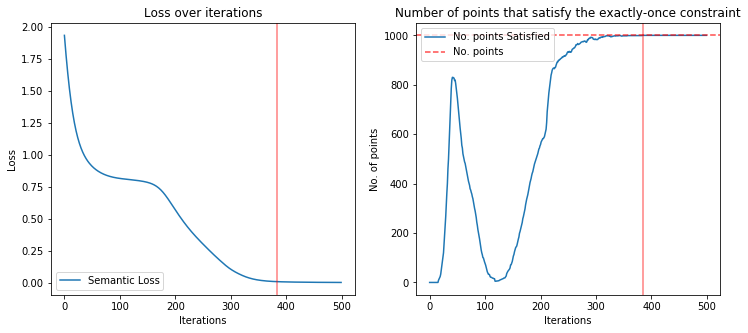

In [108]:
fig = plt.figure(figsize=(12, 5))

# first position at which # of points == 1000
sat_pos = sat_ot.index(1000)

ax = fig.add_subplot(121)
ax.plot(loss_ot, label="Semantic Loss")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)


ax = fig.add_subplot(122)
ax.plot(sat_ot, label="No. points Satisfied")
ax.axhline(1000, 0, len(sat_ot), label="No. points", linestyle="--", color="red", alpha=0.7)
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("No. of points")
ax.set_title("Number of points that satisfy the exactly-once constraint")

plt.savefig("./gaussian_blobs.png", dpi=300)

### Experiment 2

In this experiment, we want to push the network to learn the following constraint:

$$(x_1 \land x_2 \land \neg x_3) \lor (\neg x_1 \land \neg x_2 \land x_3)$$

i.e we want either the first two logits to be active or the last logit to be active

In [109]:
def sem_loss_2(probs):
    # this loss forces either
    #    (a) the first two classes to be one (together)
    # or (b) the last class to be one
    assert probs.size(0) == 3
    
    s1 = probs[0] * probs[1] * (1- probs[2])
    s2 = (1-probs[0]) * (1-probs[1]) * probs[2]

    # sl = torch.log(s1) * torch.log(s2)
#     sl = -1 * torch.log(s1 + s2 + 1e-9)
    sl = torch.min(-torch.log(s1 + 1e-9), -torch.log(s2 + 1e-9))
    
    sl = torch.clamp(sl, min=0., max=5.)
    
    return sl

In [44]:
def sat_exactly2(logits):
    assert logits.size(1) == 3
    sat = 0
    for l in logits:
        if l[0] == 1 and l[1] == 1 and l[2] == 0:
            sat += 1
        elif l[0] == 0 and l[1] == 0 and l[2] == 1:
            sat += 1
    return sat

In [45]:
a = torch.Tensor([
    [0, 0, 1],
    [1, 1, 0]
])

sat_exactly2(a)

2

In [28]:
np.random.seed(40)
torch.manual_seed(40)

net = Net()

opt = optim.Adam(net.parameters())
for i in range(3000):    
    opt.zero_grad()
    loss = net.compute_loss(X, torch.ones(X.size(0), 3))
    loss.backward()
    opt.step()
#     print(loss.item())
    
    with torch.no_grad():
        
        y_pred = torch.sigmoid(net(X))
        # accuracy_score(yy, y_pred.detach().numpy().argmax(1))
        y_pred[y_pred > 0.5] = 1
        all_ones = (y_pred == 1.0).view(-1).sum()
#         print(all_ones)
        if all_ones == np.prod(y_pred.shape):
            break

print("All ones: DONE!")            
### Now train only with the semantic loss and note the number of constraints it satisfies 
opt = optim.Adam(net.parameters(), lr=0.01)
loss_ot = []
sat_ot = []
for i in range(300):    
    opt.zero_grad()
    out = net(X)
    batch_loss = torch.zeros(X.size(0))
    for i, o in enumerate(out):
        batch_loss[i] = sem_loss_2(torch.sigmoid(o))
    loss = batch_loss.mean()
    loss.backward()
    opt.step()

    loss_ot.append(loss.item())
    
    if i % 10 == 0:
        print(logits[:3])
    
    with torch.no_grad():
        y_pred = torch.sigmoid(net(X))
        logits = copy.deepcopy(y_pred)
        logits[logits > 0.5] = 1
        logits[logits <= 0.5] = 0
        
        sat = sat_exactly2(logits)
        print(sat, loss.item())
        
        sat_ot.append(sat)

All ones: DONE!
0 2.5033671855926514
25 2.3243048191070557
120 2.148728370666504
238 1.977365255355835
312 1.8110495805740356
336 1.6507043838500977
337 1.4973170757293701
337 1.3518915176391602
369 1.2153868675231934
604 1.0886406898498535
676 0.9722882509231567
722 0.8666934370994568
961 0.7719034552574158
999 0.6876439452171326
1000 0.6133509278297424
1000 0.5482382774353027
1000 0.4913804531097412
1000 0.44179654121398926
1000 0.3985205292701721
1000 0.3606513440608978
1000 0.32738247513771057
1000 0.29801395535469055
1000 0.27195215225219727
1000 0.2486971765756607
1000 0.22784307599067688
1000 0.20905768871307373
1000 0.19206741452217102
1000 0.17664837837219238
1000 0.1626126617193222
1000 0.14981333911418915
1000 0.13812370598316193
1000 0.1274353265762329
1000 0.11765609681606293
1000 0.10870390385389328
1000 0.10050951689481735
1000 0.09301219880580902
1000 0.08615580946207047
1000 0.07988614588975906
1000 0.07415692508220673
1000 0.06892409175634384
1000 0.06414565443992615


In [29]:
logits

tensor([[1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        ...,
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.]])

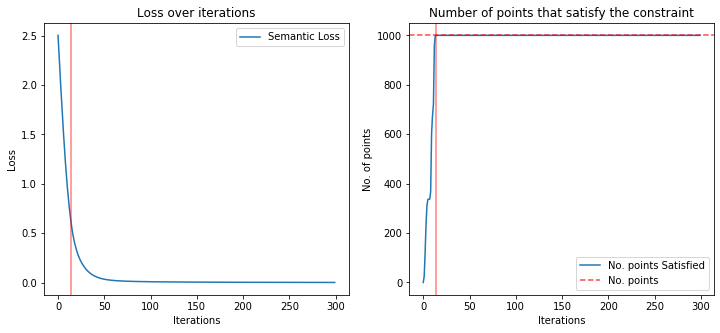

In [30]:
fig = plt.figure(figsize=(12, 5))

# first position at which # of points == 1000
sat_pos = sat_ot.index(1000)

ax = fig.add_subplot(121)
ax.plot(loss_ot, label="Semantic Loss")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)


ax = fig.add_subplot(122)
ax.plot(sat_ot, label="No. points Satisfied")
ax.axhline(1000, 0, len(sat_ot), label="No. points", linestyle="--", color="red", alpha=0.7)
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("No. of points")
ax.set_title("Number of points that satisfy the constraint")

plt.savefig("./gaussian_blobs_exp2.png", dpi=300)

### Experiment 3: Bias

In this experiment, we will investigate our intuition about the SL. We first train a network to predict the proper class in the GB dataset. Then we will use the SL to enforce the constraint defined in Experiment 2. Our hypothesis is that the network will predict (0, 0, 1) on 1/3rd of the dataset and (1, 1, 0) on 2/3rd of the dataset.      

In [128]:
def sat_exactly2_parts(logits):
    assert logits.size(1) == 3
    sat_1 = 0
    sat_2 = 0
    for l in logits:
        if l[0] == 1 and l[1] == 1 and l[2] == 0:
            sat_1 += 1
        elif l[0] == 0 and l[1] == 0 and l[2] == 1:
            sat_2 += 1
    return sat_1 + sat_2, sat_1, sat_2

In [129]:
y_2 = []

for y_i in y:
    if y_i[0] == 1. or y_i[1] == 1.:
        y_2.append([1., 1., 0.])
    else:
        y_2.append([0., 0., 1.])
        
y_2 = torch.tensor(y_2)

y_2_test = []

for y_i in y_test:
    if y_i[0] == 1. or y_i[1] == 1.:
        y_2_test.append([1., 1., 0.])
    else:
        y_2_test.append([0., 0., 1.])
        
y_2_test = torch.tensor(y_2_test)

In [139]:
np.random.seed(42)
torch.manual_seed(42)

net = Net()

opt = optim.Adam(net.parameters())
for i in range(3000):    
    opt.zero_grad()
    loss = net.compute_loss(X, y)
    loss.backward()
    opt.step()
#     print(loss.item())
    
    with torch.no_grad():
        
        y_pred = torch.sigmoid(net(X))
        y_pred[y_pred > 0.5] = 1
        acc = accuracy_score(y.argmax(1), y_pred.detach().numpy().argmax(1))
        if acc == 1.0:
            break

print("Gauss Blobs done!")

anneal_weight=1./100

### Now train only with the semantic loss and note the number of constraints it satisfies 
opt = optim.Adam(net.parameters(), lr=0.01)
loss_ot = []
loss_ot_sl = []
loss_ot_ce = []
sat_ot = []
sat_1_ot = []
sat_2_ot = []
acc_ot = []

w_s = 0.


for i in range(100):    
    opt.zero_grad()
    out = net(X)
    batch_loss = torch.zeros(X.size(0))
    for i, o in enumerate(out):
        batch_loss[i] = sem_loss_2(torch.sigmoid(o))

    sl_loss = batch_loss.mean()

    ce_loss = F.binary_cross_entropy_with_logits(out, y_2)
    ce_loss = torch.clamp(ce_loss, min=0.)

    loss    = w_s * sl_loss + ce_loss

    loss.backward()

    torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
    opt.step()

    loss_ot.append(loss.item())
    loss_ot_sl.append(sl_loss.item())
    loss_ot_ce.append(ce_loss.item())
    
    w_s = w_s + anneal_weight
    
    if i % 10 == 0:
        print(logits[:3])
    
    with torch.no_grad():
        y_pred = torch.sigmoid(net(X))        
        y_pred[y_pred >  0.5] = 1
        y_pred[y_pred <= 0.5] = 0

        acc = accuracy_score(y_2, y_pred.detach().numpy())

        acc_ot.append(acc)
        
        logits = copy.deepcopy(y_pred)
        logits[logits > 0.5] = 1
        logits[logits <= 0.5] = 0
        
        sat, sat_1, sat_2 = sat_exactly2_parts(logits)
        print(sat, loss.item(), acc)
        
        sat_ot.append(sat)
        sat_1_ot.append(sat_1)
        sat_2_ot.append(sat_2)

Gauss Blobs done!
0 0.7894572615623474 0.0
0 0.7939099073410034 0.0
0 0.7988166213035583 0.0
0 0.804211437702179 0.0
0 0.8100999593734741 0.0
0 0.8164900541305542 0.0
0 0.8233792781829834 0.0
0 0.83075350522995 0.0
1 0.8385976552963257 0.0
3 0.8468778133392334 0.002
12 0.8555677533149719 0.003
20 0.8645883798599243 0.008
37 0.8739027976989746 0.013
55 0.883475661277771 0.018
77 0.8932669758796692 0.027
93 0.9031490683555603 0.037
117 0.9130463004112244 0.044
151 0.922863245010376 0.052
175 0.9324467182159424 0.064
210 0.9416134357452393 0.084
255 0.9502379894256592 0.111
304 0.9582874774932861 0.14
354 0.9655987024307251 0.172
406 0.9719813466072083 0.21
453 0.9773109555244446 0.24
499 0.981614351272583 0.261
536 0.9848283529281616 0.287
577 0.9868615865707397 0.324
619 0.9876805543899536 0.355
654 0.9874516725540161 0.384
684 0.9862452745437622 0.405
714 0.9841156005859375 0.427
736 0.9811388254165649 0.442
752 0.9773966073989868 0.457
758 0.9731044769287109 0.463
772 0.96828019618988

In [140]:
logits

tensor([[1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        ...,
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.]])

In [141]:
sat_exactly2_parts(logits)

(1000, 1000, 0)

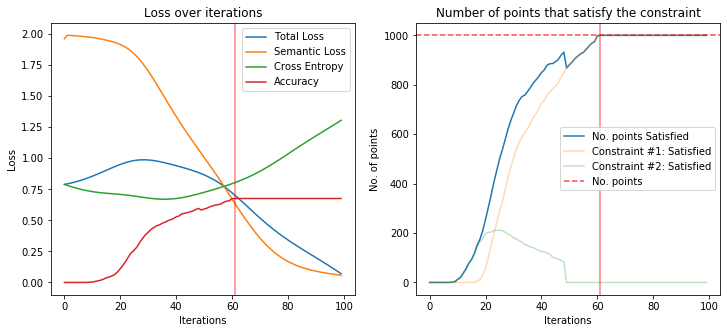

In [142]:
fig = plt.figure(figsize=(12, 5))

# first position at which # of points == 1000
sat_pos = sat_ot.index(1000)

ax = fig.add_subplot(121)
ax.plot(loss_ot, label="Total Loss")
ax.plot(loss_ot_sl, label="Semantic Loss")
ax.plot(loss_ot_ce, label="Cross Entropy")
ax.plot(acc_ot, label="Accuracy")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)


ax = fig.add_subplot(122)
ax.plot(sat_ot, label="No. points Satisfied")
ax.plot(sat_1_ot, label="Constraint #1: Satisfied", alpha=0.3)
ax.plot(sat_2_ot, label="Constraint #2: Satisfied", alpha=0.3)
ax.axhline(1000, 0, len(sat_ot), label="No. points", linestyle="--", color="red", alpha=0.7)
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("No. of points")
ax.set_title("Number of points that satisfy the constraint")

plt.savefig("./gaussian_blobs_exp3.png", dpi=300)

## Experiment 4

TODO Description

In [6]:
def experiment(net_fn, n_points = 1000, n_test=200, learning_rate=0.1, random_seed=2):
    
    def run_experiment(percent_data, w, n_iter=100, val_percent = 0.1):
        assert percent_data + val_percent <= 1.0 
        n_train = int(percent_data * X.size(0))
        n_val = int(val_percent * X.size(0))
        rand_idx = np.random.permutation(np.arange(X.size(0)))
        train_idx = rand_idx[:n_train]
        val_idx = rand_idx[n_train: n_train + n_val]
        
        X_train = X[train_idx]
        y_train = y[train_idx]
        
        X_val = X[val_idx]
        y_val = y[val_idx]
        
        net = net_fn()
        opt = optim.Adam(net.parameters())
        
        best_val_wts = net.state_dict()
        best_val_acc = float("-inf")
        
        for i in range(n_iter):
            net.train()
            opt.zero_grad()
            
            out = net(X_train)
            bce = F.binary_cross_entropy_with_logits(out, y_train)
            batch_loss = torch.zeros(X_train.size(0))
            for i, o in enumerate(out):
                batch_loss[i] = sem_loss(torch.sigmoid(o))
            sl = w * batch_loss.mean()
            loss = bce + sl
            loss.backward()
            opt.step()
            
            # compute val accuracy
            with torch.no_grad():
                net.eval()
                out = torch.sigmoid(net(X_val))
                correct = (out.argmax(dim=1) == y_val.argmax(dim=1)).sum()
                accuracy = float(correct) / X_val.size(0)

                if accuracy > best_val_acc:
                    best_val_acc = accuracy
                    best_val_wts = net.state_dict()
        
        # load with best model
        net.load_state_dict(best_val_wts)
            
        net.eval()
        with torch.no_grad():
            out = torch.sigmoid(net(X_test))
            correct = (out.argmax(dim=1) == y_test.argmax(dim=1)).sum()
            accuracy = float(correct) / X_test.size(0)
        
        print("N points: {}, w:{}, Best Val Accuracy: {}, Accuracy: {}".format(n_train, w, best_val_acc, accuracy))
            
        return {"accuracy": accuracy}
        
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    XX, yyy = make_blobs(n_points, n_features=3, random_state=random_seed)


    X = XX[:n_points - n_test]
    yy = yyy[:n_points - n_test]

    X_test = XX[n_points - n_test:]
    yy_test = yyy[n_points - n_test:]

    X = torch.FloatTensor(X)
    X_test = torch.FloatTensor(X_test)

    y = torch.zeros(X.size(0), 3)
    for idx, _ in enumerate(yy):
        y[idx, _] = 1.0

    y_test = torch.zeros(X_test.size(0), 3)
    for idx, _ in enumerate(yy_test):
        y_test[idx, _] = 1.0

    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.1, c=y)
    ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test)
    ax.view_init(elev=10, azim=45)
    ax.grid(False)
    
    plt.savefig("gauss_exp2.png")
    plt.close()
    
    w_choices = [0, 1, 2]
    percent_data = [0.1, 0.25, 0.5, 0.75, 0.9]
    experiments = []
    
    for w in w_choices:
        for p in percent_data:
            experiments.append({
                "percent_data": p,
                "w": w
            })
    
    results = []
    for experiment in experiments:
        results.append({
            "params": experiment,
            "results": run_experiment(experiment["percent_data"], experiment["w"])
        })
    
    with open("./gauss_blobs_results.json", "w") as writer:
        writer.write(json.dumps(results, indent=1))
    
    

    # convert to pytorch tensors
    
    
    
experiment(Net, random_seed=2)

N points: 80, w:0, Best Val Accuracy: 0.6875, Accuracy: 0.63
N points: 200, w:0, Best Val Accuracy: 0.325, Accuracy: 0.31
N points: 400, w:0, Best Val Accuracy: 0.3375, Accuracy: 0.405
N points: 600, w:0, Best Val Accuracy: 0.2875, Accuracy: 0.24
N points: 720, w:0, Best Val Accuracy: 0.6125, Accuracy: 0.575
N points: 80, w:1, Best Val Accuracy: 0.3, Accuracy: 0.3
N points: 200, w:1, Best Val Accuracy: 0.6625, Accuracy: 0.74
N points: 400, w:1, Best Val Accuracy: 0.525, Accuracy: 0.365
N points: 600, w:1, Best Val Accuracy: 0.0, Accuracy: 0.0
N points: 720, w:1, Best Val Accuracy: 0.6375, Accuracy: 0.72
N points: 80, w:2, Best Val Accuracy: 0.4125, Accuracy: 0.34
N points: 200, w:2, Best Val Accuracy: 0.4875, Accuracy: 0.365
N points: 400, w:2, Best Val Accuracy: 0.3125, Accuracy: 0.355
N points: 600, w:2, Best Val Accuracy: 0.025, Accuracy: 0.03
N points: 720, w:2, Best Val Accuracy: 0.6125, Accuracy: 0.555
